# Sanity Check of FedLeak (CenterCrop Generator), ImageNet(ISLVRC2012).

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=False`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_centercrop_showcase.ipynb`, with `centercrop_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:0")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

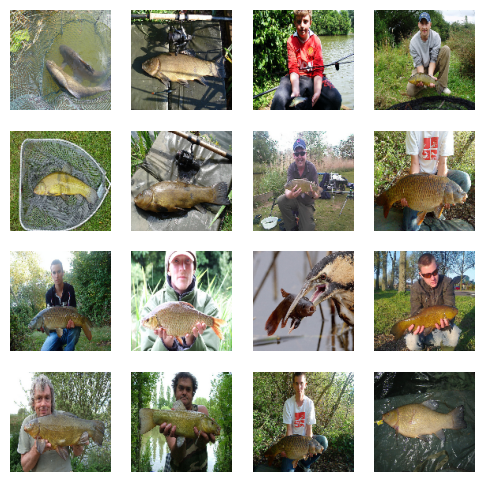

| It: 1 | Loss: -44.3447 | Time:   5.29s |


| It: 1001 | Loss: -60.6196 | Time: 566.41s |


| It: 2001 | Loss: -61.2365 | Time: 566.10s |


| It: 3001 | Loss: -61.4497 | Time: 567.10s |


| It: 4001 | Loss: -61.5598 | Time: 567.16s |


| It: 5001 | Loss: -61.6393 | Time: 567.18s |


| It: 6001 | Loss: -61.6972 | Time: 566.02s |


| It: 7001 | Loss: -61.7393 | Time: 565.59s |


| It: 8001 | Loss: -61.7679 | Time: 565.91s |


| It: 9001 | Loss: -61.7833 | Time: 565.96s |


| It: 1 | Loss: -44.5244 | Time:   0.47s |


| It: 1001 | Loss: -60.5279 | Time: 569.51s |


| It: 2001 | Loss: -61.1925 | Time: 567.86s |


| It: 3001 | Loss: -61.4268 | Time: 569.99s |


| It: 4001 | Loss: -61.5416 | Time: 567.61s |


| It: 5001 | Loss: -61.6245 | Time: 566.70s |


| It: 6001 | Loss: -61.6826 | Time: 569.09s |


| It: 7001 | Loss: -61.7291 | Time: 569.43s |


| It: 8001 | Loss: -61.7598 | Time: 570.03s |


| It: 9001 | Loss: -61.7746 | Time: 571.96s |


| It: 1 | Loss: -42.5849 | Time:   0.62s |


| It: 1001 | Loss: -60.6568 | Time: 571.50s |


| It: 2001 | Loss: -61.2463 | Time: 570.24s |


| It: 3001 | Loss: -61.4798 | Time: 569.90s |


| It: 4001 | Loss: -61.5733 | Time: 570.88s |


| It: 5001 | Loss: -61.6562 | Time: 569.44s |


| It: 6001 | Loss: -61.7069 | Time: 571.86s |


| It: 7001 | Loss: -61.7515 | Time: 570.58s |


| It: 8001 | Loss: -61.7786 | Time: 569.56s |


| It: 9001 | Loss: -61.7927 | Time: 567.45s |


| It: 1 | Loss: -43.6541 | Time:   0.62s |


| It: 1001 | Loss: -60.7902 | Time: 566.85s |


| It: 2001 | Loss: -61.3123 | Time: 566.05s |


| It: 3001 | Loss: -61.4893 | Time: 570.89s |


| It: 4001 | Loss: -61.5963 | Time: 571.06s |


| It: 5001 | Loss: -61.6687 | Time: 570.82s |


| It: 6001 | Loss: -61.7167 | Time: 570.04s |


| It: 7001 | Loss: -61.7587 | Time: 570.14s |


| It: 8001 | Loss: -61.7850 | Time: 569.37s |


| It: 9001 | Loss: -61.7971 | Time: 569.09s |


| It: 1 | Loss: -42.7734 | Time:   0.59s |


| It: 1001 | Loss: -60.9725 | Time: 564.35s |


| It: 2001 | Loss: -61.3945 | Time: 568.08s |


| It: 3001 | Loss: -61.5511 | Time: 570.72s |


| It: 4001 | Loss: -61.6413 | Time: 569.78s |


| It: 5001 | Loss: -61.6965 | Time: 570.37s |


| It: 6001 | Loss: -61.7412 | Time: 403.10s |


| It: 7001 | Loss: -61.7768 | Time: 363.60s |


| It: 8001 | Loss: -61.8014 | Time: 359.06s |


| It: 9001 | Loss: -61.8139 | Time: 358.12s |


BEST PSNR: 10.5809
MEDIAN PSNR: 10.3285
ALL PSNR: [10.2413, 10.2742, 10.3701, 10.5809, 10.5809]


<Figure size 400x300 with 0 Axes>

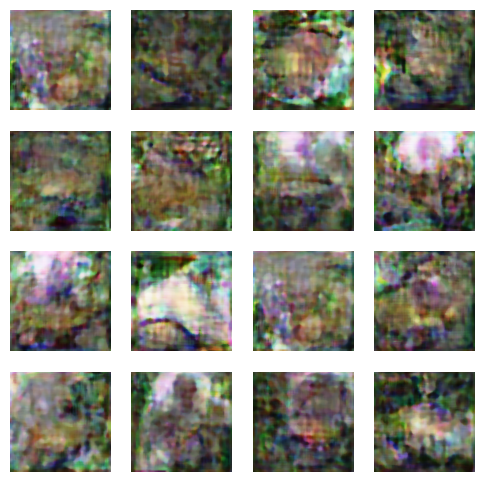

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

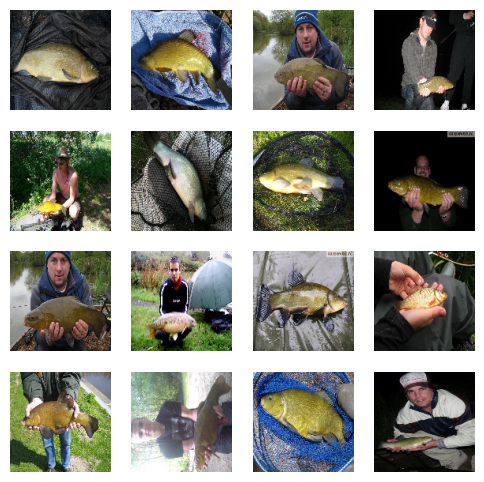

| It: 1 | Loss: -42.4191 | Time:   0.36s |


| It: 1001 | Loss: -60.6074 | Time: 358.37s |


| It: 2001 | Loss: -61.2103 | Time: 358.76s |


| It: 3001 | Loss: -61.4398 | Time: 360.03s |


| It: 4001 | Loss: -61.5491 | Time: 358.26s |


| It: 5001 | Loss: -61.6374 | Time: 358.80s |


| It: 6001 | Loss: -61.6951 | Time: 353.77s |


| It: 7001 | Loss: -61.7387 | Time: 362.23s |


| It: 8001 | Loss: -61.7672 | Time: 353.98s |


| It: 9001 | Loss: -61.7780 | Time: 361.67s |


| It: 1 | Loss: -42.8052 | Time:   0.38s |


| It: 1001 | Loss: -60.9016 | Time: 356.90s |


| It: 2001 | Loss: -61.3685 | Time: 353.58s |


| It: 3001 | Loss: -61.5201 | Time: 361.06s |


| It: 4001 | Loss: -61.6227 | Time: 362.47s |


| It: 5001 | Loss: -61.6902 | Time: 358.13s |


| It: 6001 | Loss: -61.7360 | Time: 360.14s |


| It: 7001 | Loss: -61.7726 | Time: 358.68s |


| It: 8001 | Loss: -61.7979 | Time: 357.02s |


| It: 9001 | Loss: -61.8097 | Time: 359.42s |


| It: 1 | Loss: -43.3904 | Time:   0.39s |


| It: 1001 | Loss: -60.7231 | Time: 357.39s |


| It: 2001 | Loss: -61.2580 | Time: 353.88s |


| It: 3001 | Loss: -61.4907 | Time: 358.90s |


| It: 4001 | Loss: -61.5907 | Time: 359.14s |


| It: 5001 | Loss: -61.6664 | Time: 361.43s |


| It: 6001 | Loss: -61.7186 | Time: 365.25s |


| It: 7001 | Loss: -61.7608 | Time: 359.59s |


| It: 8001 | Loss: -61.7869 | Time: 357.46s |


| It: 9001 | Loss: -61.7995 | Time: 359.79s |


| It: 1 | Loss: -41.0629 | Time:   0.37s |


| It: 1001 | Loss: -60.8893 | Time: 360.08s |


| It: 2001 | Loss: -61.3652 | Time: 358.95s |


| It: 3001 | Loss: -61.5269 | Time: 351.12s |


| It: 4001 | Loss: -61.6247 | Time: 359.73s |


| It: 5001 | Loss: -61.6829 | Time: 357.32s |


| It: 6001 | Loss: -61.7336 | Time: 358.72s |


| It: 7001 | Loss: -61.7720 | Time: 359.19s |


| It: 8001 | Loss: -61.7978 | Time: 360.63s |


| It: 9001 | Loss: -61.8105 | Time: 357.30s |


| It: 1 | Loss: -44.4008 | Time:   0.38s |


| It: 1001 | Loss: -60.4392 | Time: 358.24s |


| It: 2001 | Loss: -61.2156 | Time: 358.08s |


| It: 3001 | Loss: -61.4369 | Time: 358.94s |


| It: 4001 | Loss: -61.5605 | Time: 358.95s |


| It: 5001 | Loss: -61.6387 | Time: 352.82s |


| It: 6001 | Loss: -61.7039 | Time: 358.84s |


| It: 7001 | Loss: -61.7479 | Time: 356.77s |


| It: 8001 | Loss: -61.7763 | Time: 357.44s |


| It: 9001 | Loss: -61.7908 | Time: 355.46s |


BEST PSNR: 10.1401
MEDIAN PSNR: 9.8919
ALL PSNR: [9.4279, 10.1357, 10.0495, 9.7063, 9.7063]


<Figure size 400x300 with 0 Axes>

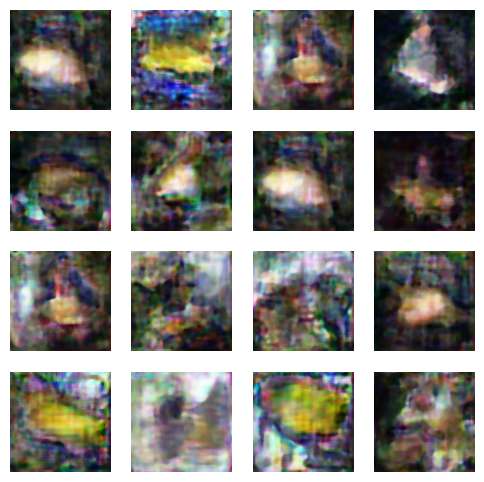

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

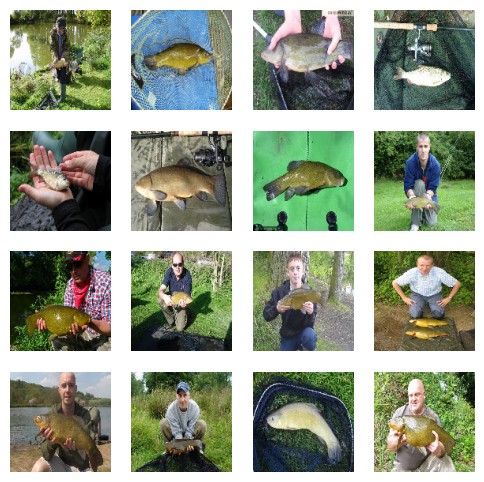

| It: 1 | Loss: -41.3817 | Time:   0.36s |


| It: 1001 | Loss: -60.9202 | Time: 357.06s |


| It: 2001 | Loss: -61.4008 | Time: 357.80s |


| It: 3001 | Loss: -61.5622 | Time: 353.50s |


| It: 4001 | Loss: -61.6507 | Time: 363.18s |


| It: 5001 | Loss: -61.7121 | Time: 358.04s |


| It: 6001 | Loss: -61.7576 | Time: 357.48s |


| It: 7001 | Loss: -61.7913 | Time: 356.07s |


| It: 8001 | Loss: -61.8151 | Time: 357.46s |


| It: 9001 | Loss: -61.8268 | Time: 358.38s |


| It: 1 | Loss: -42.4679 | Time:   0.37s |


| It: 1001 | Loss: -60.7631 | Time: 358.50s |


| It: 2001 | Loss: -61.3198 | Time: 355.50s |


| It: 3001 | Loss: -61.5118 | Time: 360.81s |


| It: 4001 | Loss: -61.6023 | Time: 356.42s |


| It: 5001 | Loss: -61.6757 | Time: 357.26s |


| It: 6001 | Loss: -61.7298 | Time: 352.71s |


| It: 7001 | Loss: -61.7692 | Time: 354.58s |


| It: 8001 | Loss: -61.7951 | Time: 359.72s |


| It: 9001 | Loss: -61.8080 | Time: 358.53s |


| It: 1 | Loss: -43.7210 | Time:   0.37s |


| It: 1001 | Loss: -61.0597 | Time: 357.78s |


| It: 2001 | Loss: -61.4132 | Time: 358.57s |


| It: 3001 | Loss: -61.5711 | Time: 360.62s |


| It: 4001 | Loss: -61.6540 | Time: 360.57s |


| It: 5001 | Loss: -61.7090 | Time: 364.30s |


| It: 6001 | Loss: -61.7555 | Time: 360.57s |


| It: 7001 | Loss: -61.7885 | Time: 361.75s |


| It: 8001 | Loss: -61.8124 | Time: 361.39s |


| It: 9001 | Loss: -61.8238 | Time: 361.56s |


| It: 1 | Loss: -44.8992 | Time:   0.40s |


| It: 1001 | Loss: -60.9387 | Time: 368.77s |


| It: 2001 | Loss: -61.3864 | Time: 364.16s |


| It: 3001 | Loss: -61.5548 | Time: 365.16s |


| It: 4001 | Loss: -61.6353 | Time: 359.85s |


| It: 5001 | Loss: -61.6982 | Time: 361.58s |


| It: 6001 | Loss: -61.7450 | Time: 359.46s |


| It: 7001 | Loss: -61.7814 | Time: 358.58s |


| It: 8001 | Loss: -61.8060 | Time: 362.35s |


| It: 9001 | Loss: -61.8179 | Time: 354.75s |


| It: 1 | Loss: -42.3638 | Time:   0.36s |


| It: 1001 | Loss: -60.9721 | Time: 348.17s |


| It: 2001 | Loss: -61.3878 | Time: 351.52s |


| It: 3001 | Loss: -61.5483 | Time: 351.38s |


| It: 4001 | Loss: -61.6415 | Time: 351.78s |


| It: 5001 | Loss: -61.7009 | Time: 352.59s |


| It: 6001 | Loss: -61.7496 | Time: 352.73s |


| It: 7001 | Loss: -61.7833 | Time: 349.71s |


| It: 8001 | Loss: -61.8075 | Time: 355.07s |


| It: 9001 | Loss: -61.8196 | Time: 351.92s |


BEST PSNR: 10.7633
MEDIAN PSNR: 10.5279
ALL PSNR: [10.3742, 10.7633, 10.6546, 10.4486, 10.4486]


<Figure size 400x300 with 0 Axes>

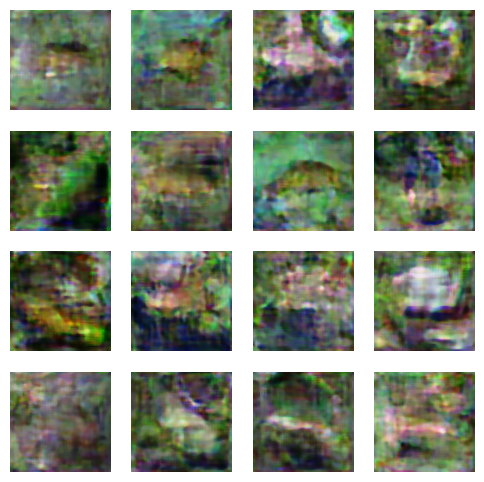

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

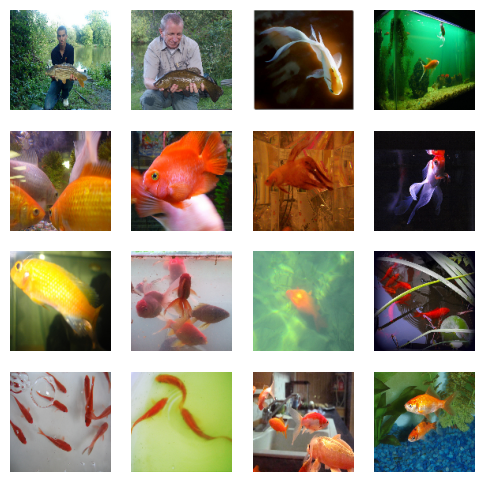

| It: 1 | Loss: -21.9802 | Time:   0.35s |


| It: 1001 | Loss: -61.1554 | Time: 353.14s |


| It: 2001 | Loss: -61.5433 | Time: 354.23s |


| It: 3001 | Loss: -61.6961 | Time: 350.84s |


| It: 4001 | Loss: -61.7780 | Time: 355.44s |


| It: 5001 | Loss: -61.8303 | Time: 354.28s |


| It: 6001 | Loss: -61.8674 | Time: 352.64s |


| It: 7001 | Loss: -61.8916 | Time: 354.98s |


| It: 8001 | Loss: -61.9105 | Time: 354.05s |


| It: 9001 | Loss: -61.9187 | Time: 354.95s |


| It: 1 | Loss: -12.7037 | Time:   0.37s |


| It: 1001 | Loss: -61.1757 | Time: 354.45s |


| It: 2001 | Loss: -61.5291 | Time: 351.79s |


| It: 3001 | Loss: -61.6476 | Time: 348.10s |


| It: 4001 | Loss: -61.7173 | Time: 353.11s |


| It: 5001 | Loss: -61.7691 | Time: 350.47s |


| It: 6001 | Loss: -61.8087 | Time: 350.16s |


| It: 7001 | Loss: -61.8391 | Time: 351.73s |


| It: 8001 | Loss: -61.8588 | Time: 355.35s |


| It: 9001 | Loss: -61.8690 | Time: 354.30s |


| It: 1 | Loss: -31.5481 | Time:   0.38s |


| It: 1001 | Loss: -61.1221 | Time: 355.67s |


| It: 2001 | Loss: -61.5818 | Time: 355.63s |


| It: 3001 | Loss: -61.7179 | Time: 354.54s |


| It: 4001 | Loss: -61.7889 | Time: 355.83s |


| It: 5001 | Loss: -61.8321 | Time: 349.27s |


| It: 6001 | Loss: -61.8662 | Time: 354.38s |


| It: 7001 | Loss: -61.8929 | Time: 352.78s |


| It: 8001 | Loss: -61.9089 | Time: 354.99s |


| It: 9001 | Loss: -61.9162 | Time: 349.81s |


| It: 1 | Loss: -25.3991 | Time:   0.38s |


| It: 1001 | Loss: -61.1136 | Time: 354.52s |


| It: 2001 | Loss: -61.5447 | Time: 354.34s |


| It: 3001 | Loss: -61.6842 | Time: 353.11s |


| It: 4001 | Loss: -61.7563 | Time: 354.75s |


| It: 5001 | Loss: -61.8050 | Time: 352.11s |


| It: 6001 | Loss: -61.8480 | Time: 355.40s |


| It: 7001 | Loss: -61.8768 | Time: 352.88s |


| It: 8001 | Loss: -61.8940 | Time: 353.28s |


| It: 9001 | Loss: -61.9036 | Time: 351.67s |


| It: 1 | Loss: -26.4685 | Time:   0.35s |


| It: 1001 | Loss: -60.9816 | Time: 354.54s |


| It: 2001 | Loss: -61.4675 | Time: 357.19s |


| It: 3001 | Loss: -61.6062 | Time: 354.71s |


| It: 4001 | Loss: -61.6937 | Time: 351.43s |


| It: 5001 | Loss: -61.7623 | Time: 353.04s |


| It: 6001 | Loss: -61.8204 | Time: 354.86s |


| It: 7001 | Loss: -61.8614 | Time: 354.97s |


| It: 8001 | Loss: -61.8844 | Time: 356.63s |


| It: 9001 | Loss: -61.8969 | Time: 354.46s |


BEST PSNR: 10.3483
MEDIAN PSNR: 10.0694
ALL PSNR: [10.3275, 9.6105, 10.1683, 10.3483, 10.3483]


<Figure size 400x300 with 0 Axes>

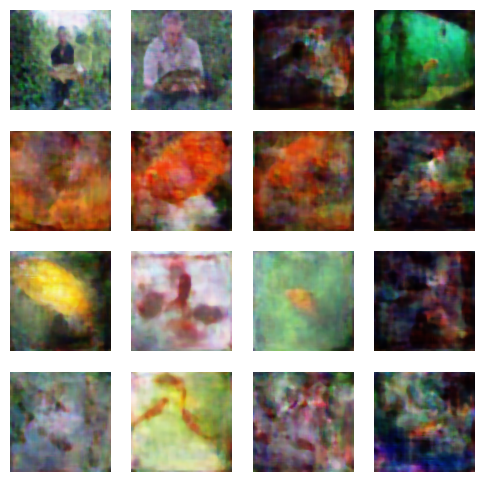

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

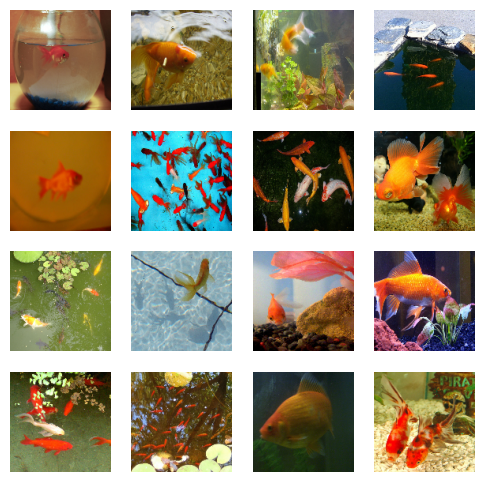

| It: 1 | Loss: -44.7950 | Time:   0.34s |


| It: 1001 | Loss: -61.2019 | Time: 353.57s |


| It: 2001 | Loss: -61.5244 | Time: 353.81s |


| It: 3001 | Loss: -61.6430 | Time: 353.33s |


| It: 4001 | Loss: -61.7169 | Time: 355.25s |


| It: 5001 | Loss: -61.7651 | Time: 354.91s |


| It: 6001 | Loss: -61.8015 | Time: 352.50s |


| It: 7001 | Loss: -61.8291 | Time: 353.97s |


| It: 8001 | Loss: -61.8492 | Time: 356.08s |


| It: 9001 | Loss: -61.8583 | Time: 354.03s |


| It: 1 | Loss: -44.8885 | Time:   0.39s |


| It: 1001 | Loss: -61.0332 | Time: 350.07s |


| It: 2001 | Loss: -61.4462 | Time: 353.85s |


| It: 3001 | Loss: -61.6027 | Time: 349.51s |


| It: 4001 | Loss: -61.6887 | Time: 353.73s |


| It: 5001 | Loss: -61.7438 | Time: 354.82s |


| It: 6001 | Loss: -61.7878 | Time: 352.17s |


| It: 7001 | Loss: -61.8174 | Time: 350.11s |


| It: 8001 | Loss: -61.8378 | Time: 350.57s |


| It: 9001 | Loss: -61.8478 | Time: 355.34s |


| It: 1 | Loss: -45.3702 | Time:   0.39s |


| It: 1001 | Loss: -60.8244 | Time: 355.12s |


| It: 2001 | Loss: -61.3575 | Time: 350.83s |


| It: 3001 | Loss: -61.5504 | Time: 354.29s |


| It: 4001 | Loss: -61.6659 | Time: 352.45s |


| It: 5001 | Loss: -61.7245 | Time: 330.01s |


| It: 6001 | Loss: -61.7682 | Time: 333.61s |


| It: 7001 | Loss: -61.8063 | Time: 332.57s |


| It: 8001 | Loss: -61.8284 | Time: 333.16s |


| It: 9001 | Loss: -61.8395 | Time: 333.26s |


| It: 1 | Loss: -44.7403 | Time:   0.32s |


| It: 1001 | Loss: -61.0609 | Time: 330.17s |


| It: 2001 | Loss: -61.4629 | Time: 332.44s |


| It: 3001 | Loss: -61.5975 | Time: 332.02s |


| It: 4001 | Loss: -61.6783 | Time: 323.60s |


| It: 5001 | Loss: -61.7348 | Time: 330.42s |


| It: 6001 | Loss: -61.7792 | Time: 331.51s |


| It: 7001 | Loss: -61.8105 | Time: 332.79s |


| It: 8001 | Loss: -61.8304 | Time: 333.16s |


| It: 9001 | Loss: -61.8417 | Time: 332.98s |


| It: 1 | Loss: -45.7306 | Time:   0.33s |


| It: 1001 | Loss: -60.9513 | Time: 326.96s |


| It: 2001 | Loss: -61.3955 | Time: 321.91s |


| It: 3001 | Loss: -61.5736 | Time: 331.51s |


| It: 4001 | Loss: -61.6667 | Time: 325.06s |


| It: 5001 | Loss: -61.7270 | Time: 332.72s |


| It: 6001 | Loss: -61.7722 | Time: 328.50s |


| It: 7001 | Loss: -61.8056 | Time: 332.63s |


| It: 8001 | Loss: -61.8267 | Time: 332.43s |


| It: 9001 | Loss: -61.8376 | Time: 333.72s |


BEST PSNR: 10.5033
MEDIAN PSNR: 10.1912
ALL PSNR: [10.2490, 10.5033, 10.1503, 9.7998, 9.7998]


<Figure size 400x300 with 0 Axes>

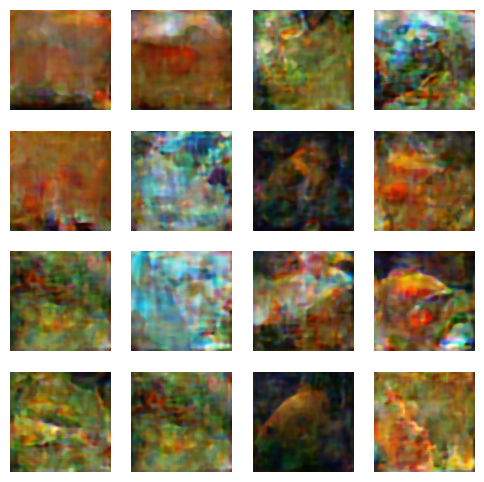

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)